# Impact of resolution and numeric schemas over trajectories predictions quality

In [1]:
import numpy as np
import xarray as xr
from math import *
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import pyplot as plt

import stagem1.temporal_integration as sti
import stagem1.int_temp_integration as iti
import xsimlab as xs
from scipy.stats import norm

In [2]:
a=iti.SetUp()
a.out_ds

<xarray.Dataset>
Dimensions:                 (a: 100, otime: 143, t: 150, time: 144, x: 410)
Coordinates:
  * a                       (a) float64 0.0 2.02e+03 4.04e+03 ... 1.98e+05 2e+05
  * otime                   (otime) int64 0 3600 7200 ... 504000 507600 511200
  * t                       (t) float64 -7.2e+03 -3.6e+03 ... 5.292e+05
  * time                    (time) int64 0 3600 7200 ... 507600 511200 514800
  * x                       (x) float64 -1.037e+05 -1.027e+05 ... 3.053e+05
    otime_day               (otime) float64 0.0 0.04167 0.08333 ... 5.875 5.917
Data variables: (12/22)
    init__N                 int64 100
    init__maxi              float64 2e+05
    init__mini              int64 0
    position__p             (otime, a) float64 0.0 2.02e+03 ... 2.517e+05
    v_field__advected       int64 1
    v_field__k              float64 6.283e-05
    ...                      ...
    velocity__v             (otime, a) float64 0.2 0.1992 ... 0.1579 0.1468
    position_km             (otime, a) float64 0.0 2.02 4.04 ... 249.6 251.7
    displacement            (otime, a) float64 0.0 0.0 ... 5.163e+04 5.17e+04
    displacement_km         (otime, a) float64 0.0 0.0 0.0 ... 51.58 51.63 51.7
    velocity_field          (t, x) float64 0.1652 0.1603 ... 0.09121 0.08498
    CFL                     float64 0.72


First row: trajectories with bilinear interpolation and without interpolation  
Second row: trajectories with Lagrange interpolation and without interpolation
Third row: difference of displacement between bilinear interpolation and without interpolation trajectories
Fourth row: difference of displacement between Lagrange interpolation and without interpolation trajectories

## Varying grid time step dt

In [2]:
T=[i*sti.h2s for i in [1/2,1,2,5,7,10]]

def change_dt_RK4(DT, **args):
    x=iti.SetUp(intmethod=iti.Runge_Kutta4, **args)
    y=sti.SetUp(intmethod=sti.Runge_Kutta4, **args)
    R_legend=['Bilinear interpolation', 'Lagrange interpolation']
    C_legend=[r"$dt=$"+str(t/3600)+'h\n CFL='+str(x['CFL']) for t in T]

    fig, axes = plt.subplots(ncols=len(T),nrows=4, figsize=(24,12),sharex='all')
    for i in range(len(T)):
        x.update_parameters(v_field__t_step=T[i], v_field__t_i=-T[i])
        x['p'].isel(a=slice(0,None,50)).plot(x='otime_day',hue='a', ax=axes[0][i], label=x.out_ds.a.isel(a=slice(0,None,50)).values)
        y['p'].isel(a=slice(0,None,50)).plot(x='otime_day',hue='a', ax=axes[0][i], label=x.out_ds.a.isel(a=slice(0,None,50)).values)
        (x['p']-y['p']).plot(x='otime_day',hue='a', ax=axes[2][i], label=x.out_ds.a.values)
        axes[0][i].set_ylabel('Displacement difference [m]')
        axes[0][i].annotate(C_legend[i], xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline')
    x.update_parameters(velocity__inter_method='lagrange')
    for i in range(len(T)):
        x.update_parameters(v_field__t_step=T[i])
        x['p'].isel(a=slice(0,None,50)).plot(x='otime_day', hue='a', ax=axes[1][i], label=x.out_ds.a.isel(a=slice(0,None,50)).values)
        y['p'].isel(a=slice(0,None,50)).plot(x='otime_day', hue='a', ax=axes[1][i], label=x.out_ds.a.isel(a=slice(0,None,50)).values)
        (x['p']-y['p']).plot(x='otime_day',hue='a', ax=axes[3][i], label=x.out_ds.a.values)
        axes[1][i].set_ylabel('Displacement difference [m]')

    ##Only one legend for all    
    lines, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(lines, labels, title="Initial position [m]:", loc="upper right", bbox_transform=fig.transFigure)
    for i in range(len(T)):
        axes[0][i].get_legend().remove()
        axes[1][i].get_legend().remove()
        axes[2][i].get_legend().remove()
        axes[3][i].get_legend().remove()
    
    for j in range (2):
        axes[j,0].annotate(R_legend[j], xy=(0, 0.5), xytext=(-axes[j,0].yaxis.labelpad - 4, 0), xycoords=axes[j,0].yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation='vertical')    

    plt.tight_layout(rect=[0,0,0.9,1])
    plt.draw()


### Unadvected case

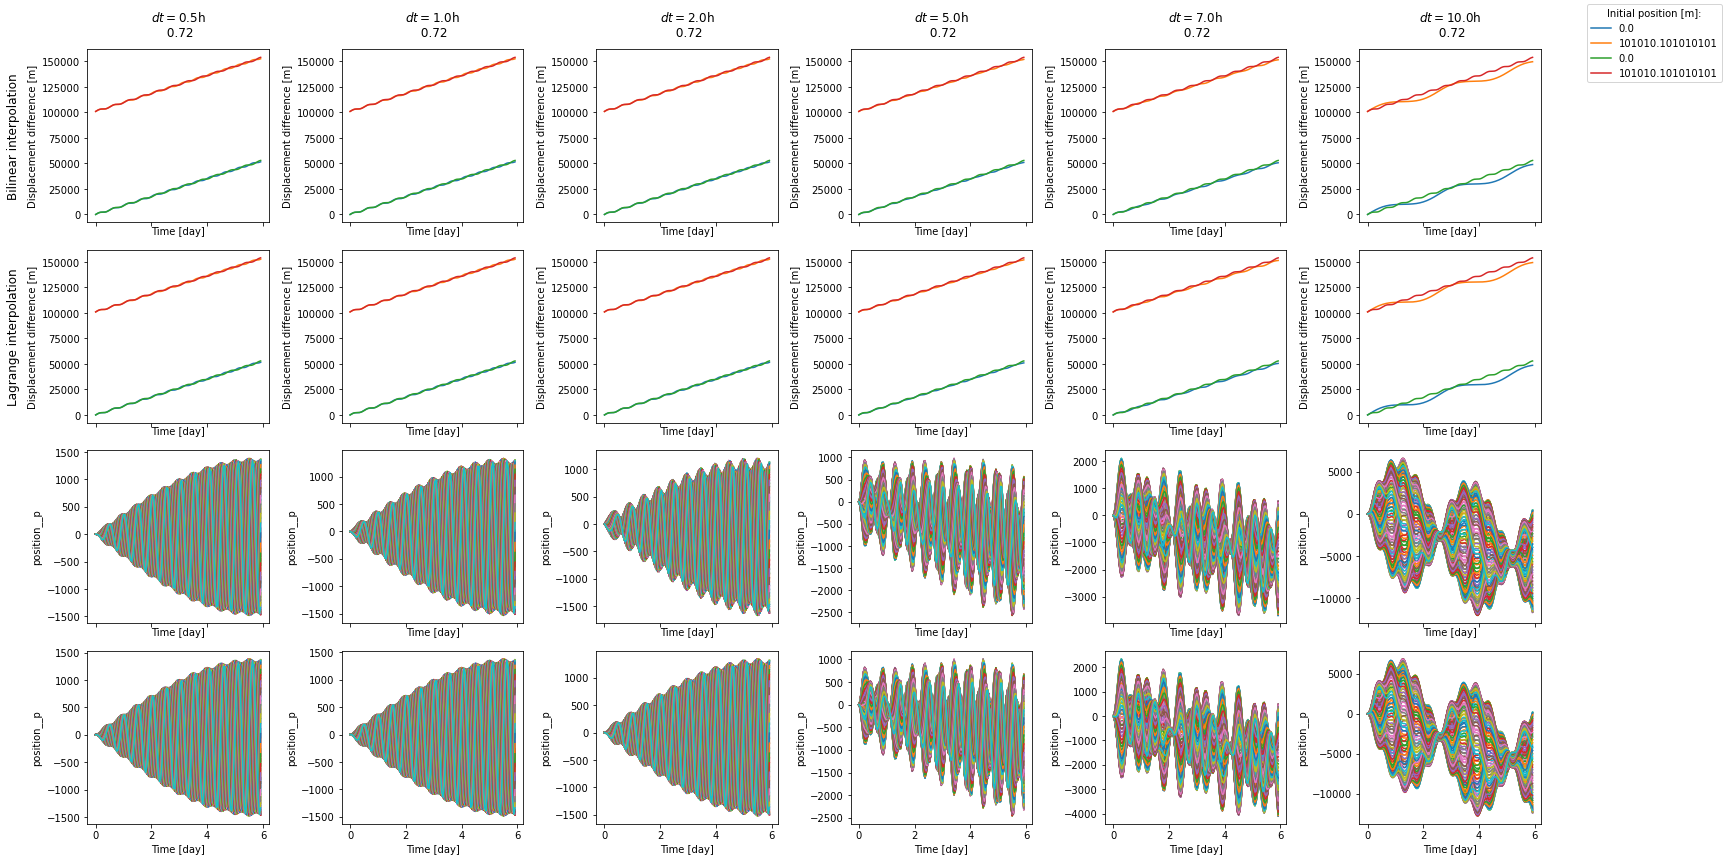

In [3]:
change_dt_RK4(T,advected=0)

#### $U_w=0$

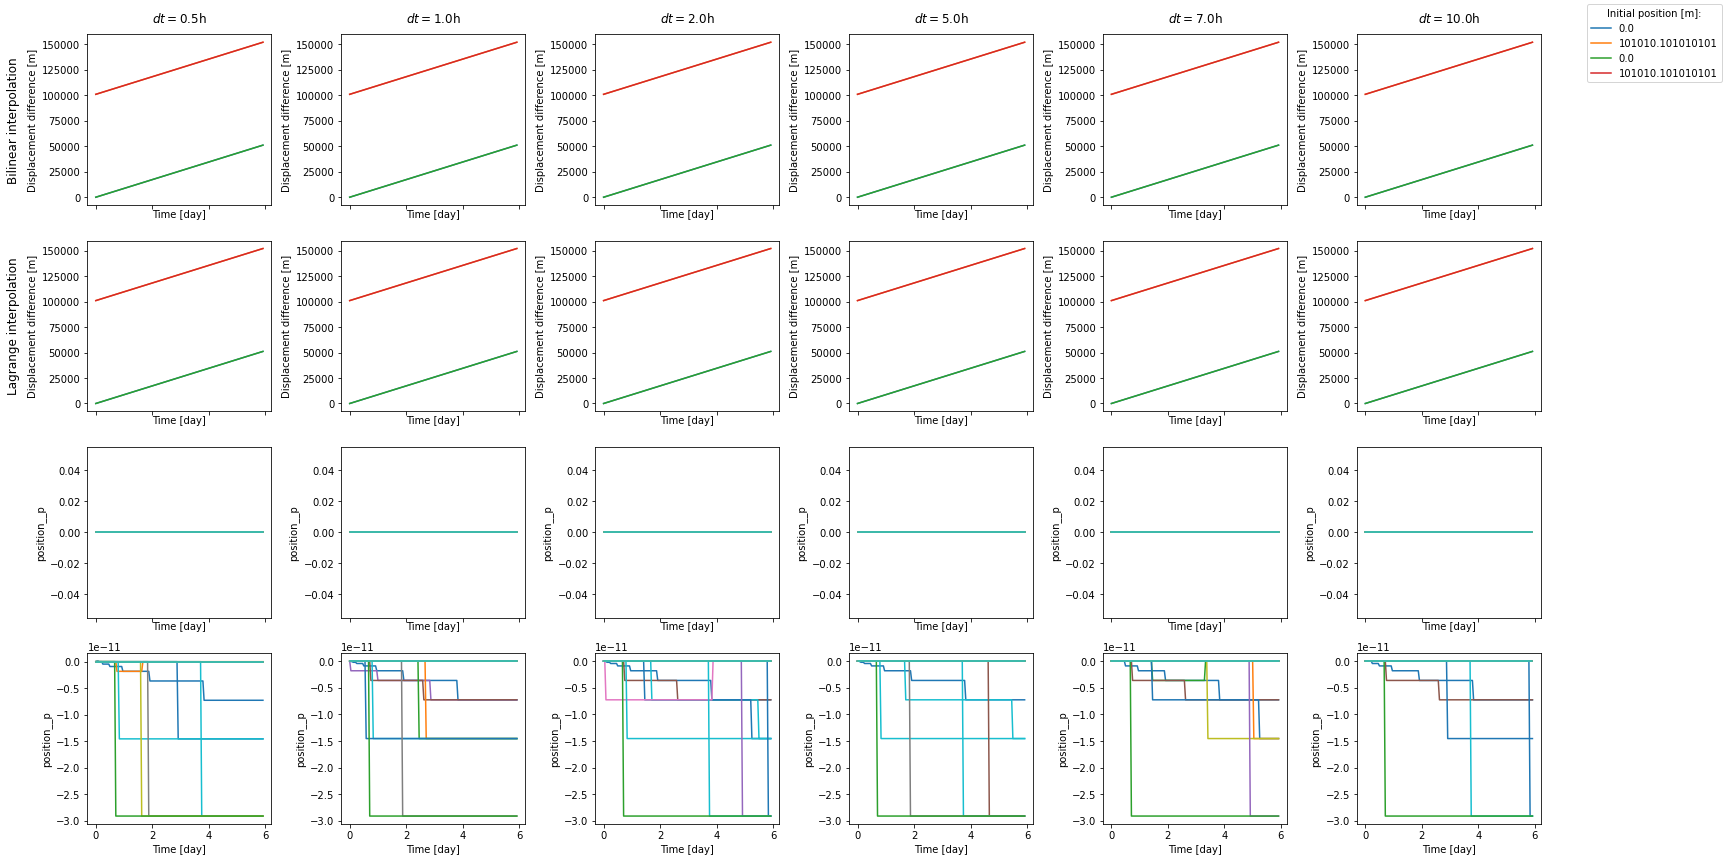

In [3]:
change_dt_RK4(T,advected=0, uw=0)

For big $\delta t$, trajectories are affected (period grows?)  
For bilinear interpolation error grows from ~1.5 m at $\delta t=0.5 h$ to ~13000 m at $\delta t=10 h$  
For Lagrange interpolation error grows from 0.001 m at $\delta t=0.5 h$ to ~13000 m at $\delta t=10 h$
The gap between Lagrange and Bilinear errors seems to be bridged as $\delta t$ grows

### Advected case

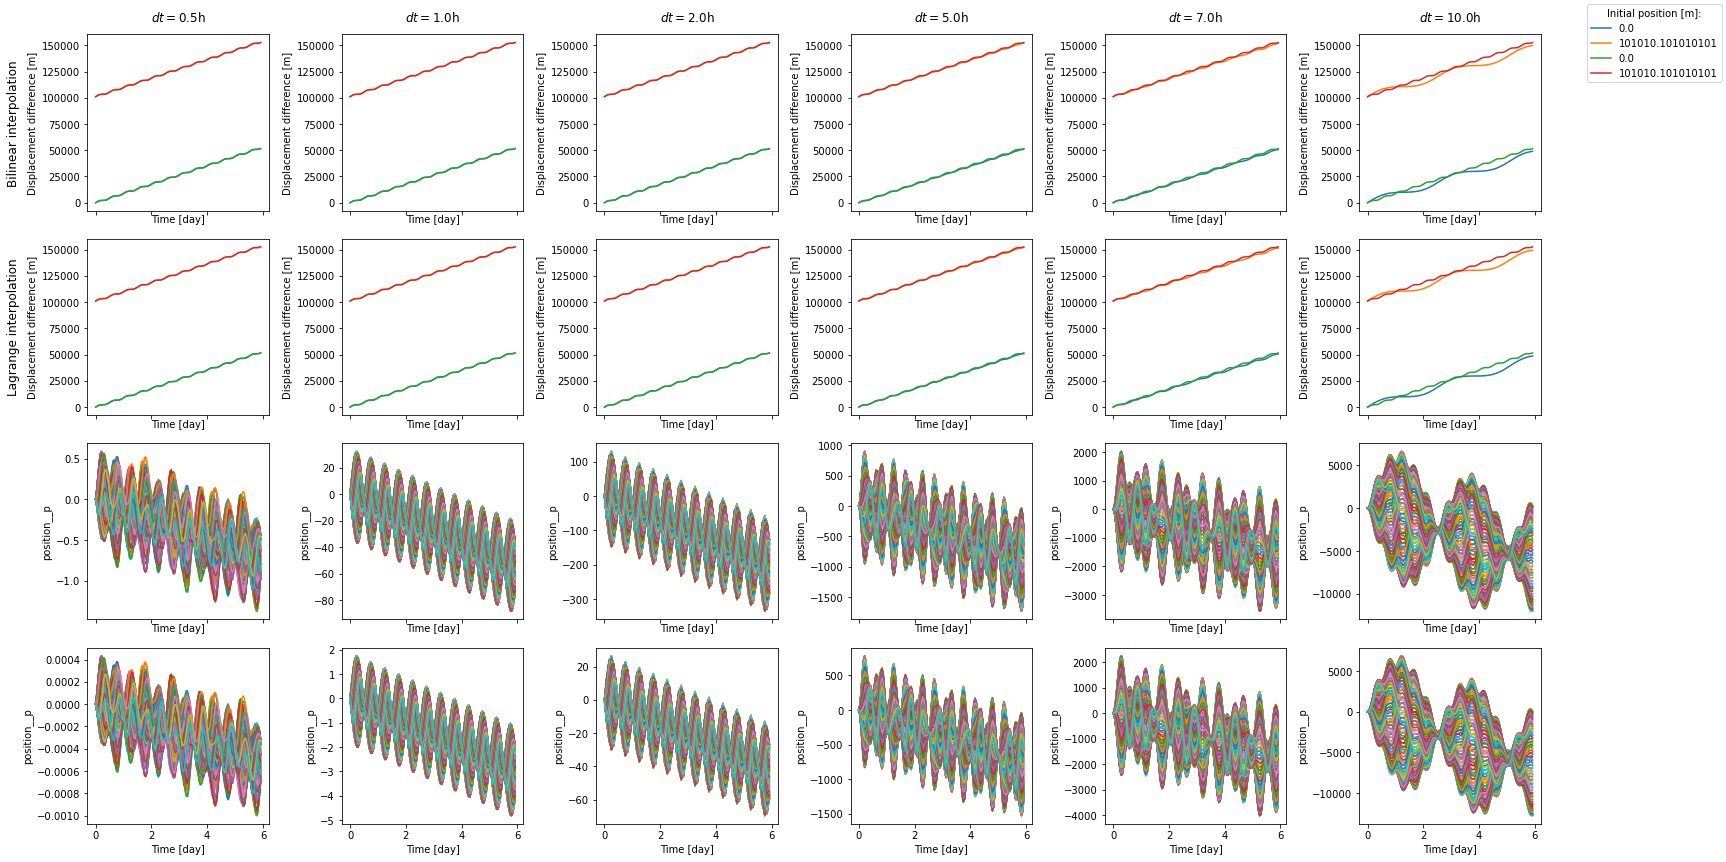

In [6]:
change_dt_RK4(T)

## In convergence domain

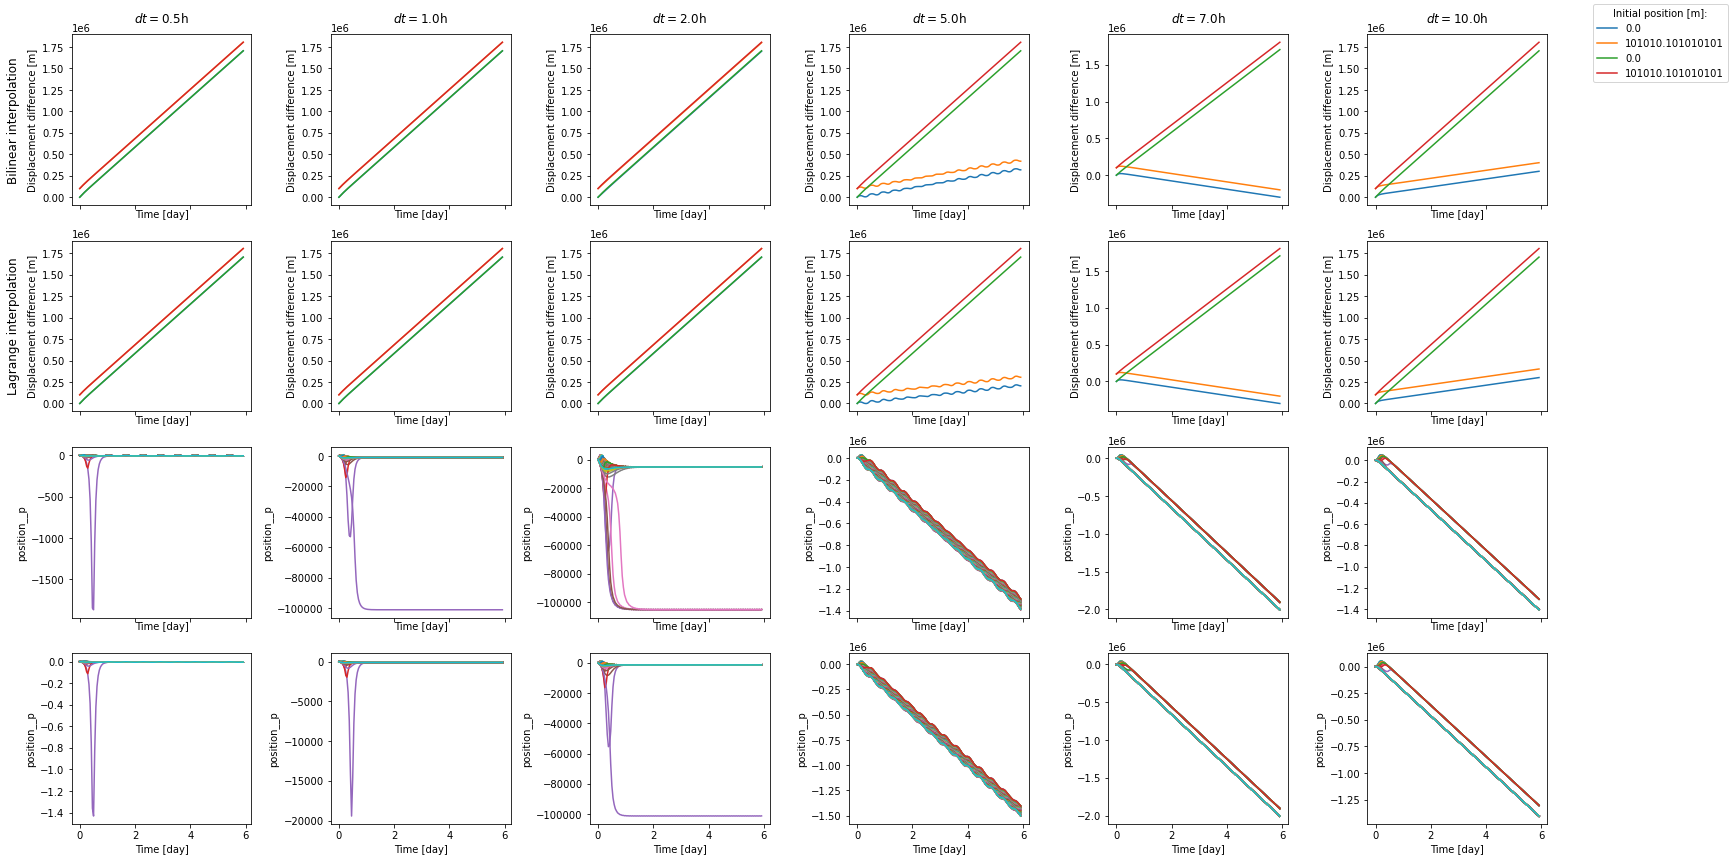

In [10]:
change_dt_RK4(T, um=1, uw=3)

# Varying Lagrangian time step $\delta t$

In [9]:
DT=[i*sti.h2s for i in [0.2,0.5,2/3,1,2,3,5]]
ODT=[i*sti.h2s for i in [1,1,2,1,2,3,5]]

def change_delta_t_RK4(DT,ODT, **args):
    T=[list(np.arange(0,sti.d2s*6, t))for t in DT]
    OT=[list(np.arange(0,sti.d2s*6-t, t))for t in ODT]
    x=iti.SetUp(intmethod=iti.Runge_Kutta4, **args)
    y=sti.SetUp(intmethod=sti.Runge_Kutta4, **args)

    R_legend=['Bilinear interpolation', 'Lagrange interpolation']
    C_legend=[r"$\delta t=$"+str(t/3600)+'h' for t in DT]

    fig, axes = plt.subplots(ncols=len(T),nrows=4, figsize=(24,12),sharex='all')
    for i in range(len(T)):
        x.update_clock(time=T[i], otime=OT[i])
        y.update_clock(time=T[i], otime=OT[i])
        x['p'].isel(a=slice(0,None,20)).plot(x='otime_day',hue='a', ax=axes[0][i], label=x.out_ds.a.isel(a=slice(0,None,20)).values)
        y['p'].isel(a=slice(0,None,20)).plot(x='otime_day',hue='a', ax=axes[0][i], label=x.out_ds.a.isel(a=slice(0,None,20)).values)
        (x['p']-y['p']).plot(x='otime_day',hue='a', ax=axes[2][i], label=x.out_ds.a.values)
        axes[0][i].set_ylabel('Displacement difference [m]')
        axes[0][i].annotate(C_legend[i]+'\n CFL='+str(x['CFL']), xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline')
    
    x.update_parameters(velocity__inter_method='lagrange')
    for i in range(len(T)):
        x.update_clock(time=T[i], otime=OT[i])
        y.update_clock(time=T[i], otime=OT[i])
        x['p'].isel(a=slice(0,None,20)).plot(x='otime_day', hue='a', ax=axes[1][i], label=x.out_ds.a.isel(a=slice(0,None,20)).values)
        y['p'].isel(a=slice(0,None,20)).plot(x='otime_day', hue='a', ax=axes[1][i], label=x.out_ds.a.isel(a=slice(0,None,20)).values)
        (x['p']-y['p']).plot(x='otime_day',hue='a', ax=axes[3][i], label=x.out_ds.a.values)
        axes[1][i].set_ylabel('Position [m]')
        axes[2][i].set_ylabel('Displacement difference [m]')

    ##Only one legend for all    
    lines, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(lines, labels, title="Initial position [m]:", loc="upper right", bbox_transform=fig.transFigure)
    for i in range(len(T)):
        axes[0][i].get_legend().remove()
        axes[1][i].get_legend().remove()
        axes[2][i].get_legend().remove()
        axes[3][i].get_legend().remove()
    

    for j in range (2):
        axes[j,0].annotate(R_legend[j], xy=(0, 0.5), xytext=(-axes[j,0].yaxis.labelpad - 4, 0), xycoords=axes[j,0].yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation='vertical')    

    plt.tight_layout(rect=[0,0,0.9,1])
    plt.draw()

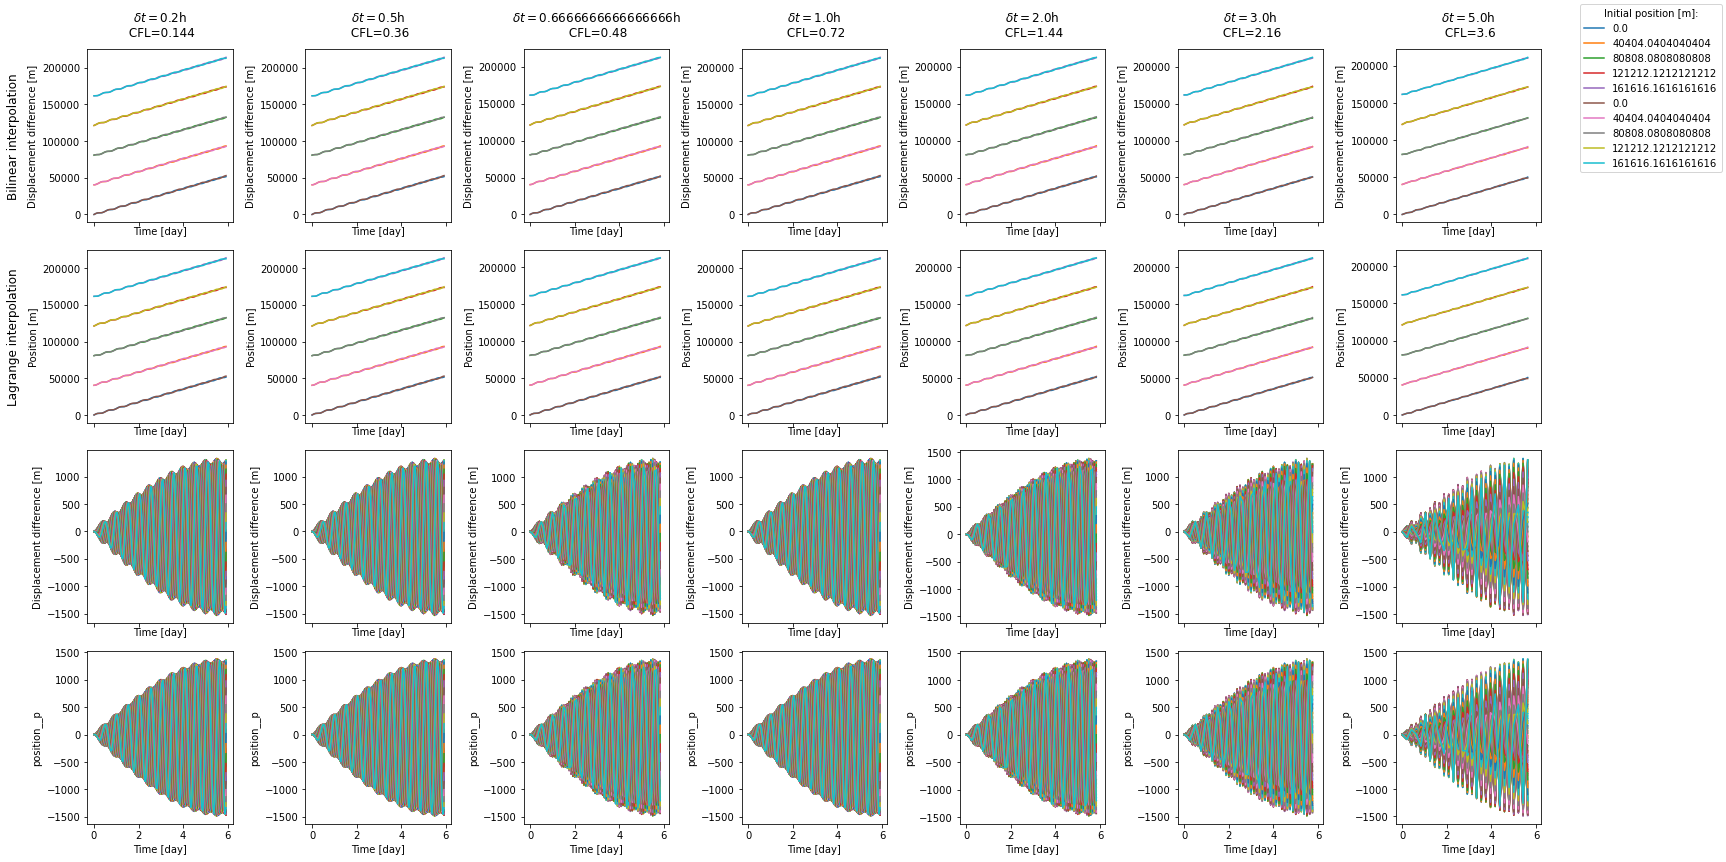

In [10]:
change_delta_t_RK4(DT,ODT, advected=0)

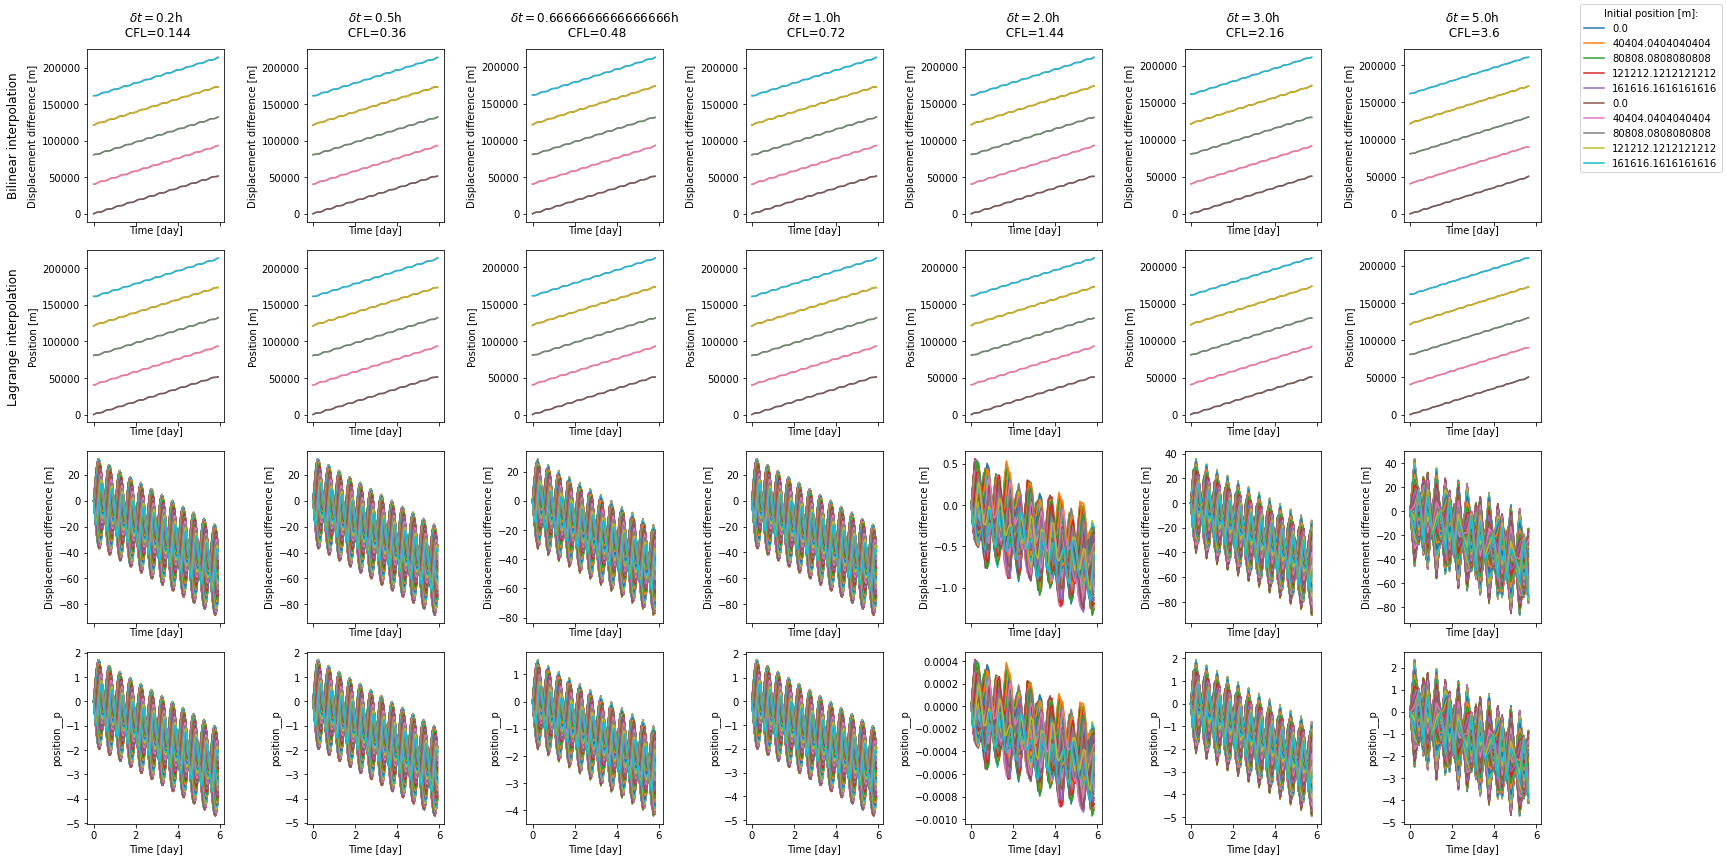

In [11]:
change_delta_t_RK4(DT,ODT)